In [1]:
# Initial imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Create data paths
cab_path = 'cab_rides.csv'
weather_path = 'weather.csv'

In [3]:
from datetime import datetime
import pytz

# Convert epoch (unix) time to datetime
def epoch_conversion(epoch):
    utc_datetime = datetime.fromtimestamp(epoch)
    local_timezone = pytz.timezone('US/Eastern')
    local_datetime = utc_datetime.replace(tzinfo=pytz.utc)
    local_datetime = local_datetime.astimezone(local_timezone)
    return local_datetime
    
# Convert epoch time (milliseconds) to datetime
def epoch_conversion_milli(epoch):
    epoch /= 1000
    utc_datetime = datetime.fromtimestamp(epoch)
    local_timezone = pytz.timezone('US/Eastern')
    local_datetime = utc_datetime.replace(tzinfo=pytz.utc)
    local_datetime = local_datetime.astimezone(local_timezone)
    return local_datetime

# Wrangle Data

In [4]:
def wrangle(cab_path, weather_path):         
    
    # Read in the data
    cab_df = pd.read_csv(cab_path)
    weather_df = pd.read_csv(weather_path)
    
    # We only want Lyft rides (Drop Uber rides)
    cab_df = cab_df[cab_df['cab_type'] == 'Lyft']
    
    # Drop High Cardinality Columns
    cab_df.drop(columns=['cab_type', 'id'], inplace=True)  
    
    # Convert epoch time to datetime
    cab_df['time_stamp'] = cab_df['time_stamp'].apply(epoch_conversion_milli)
    weather_df['time_stamp'] = weather_df['time_stamp'].apply(epoch_conversion) 
    
    # cab_df feature engineering
    cab_df['year'] = pd.DatetimeIndex(cab_df['time_stamp']).year
    cab_df['month'] = pd.DatetimeIndex(cab_df['time_stamp']).month
    cab_df['day'] = pd.DatetimeIndex(cab_df['time_stamp']).day
    cab_df['hour'] = pd.DatetimeIndex(cab_df['time_stamp']).hour
    cab_df['weekday'] = pd.DatetimeIndex(cab_df['time_stamp']).weekday

    # weather_df feature engineering
    weather_df['year'] = pd.DatetimeIndex(weather_df['time_stamp']).year
    weather_df['month'] = pd.DatetimeIndex(weather_df['time_stamp']).month
    weather_df['day'] = pd.DatetimeIndex(weather_df['time_stamp']).day
    weather_df['hour'] = pd.DatetimeIndex(weather_df['time_stamp']).hour
    weather_df['weekday'] = pd.DatetimeIndex(weather_df['time_stamp']).weekday
    
    # Merge cab_df & weather_df  
    df = pd.merge(cab_df, weather_df, 
                      how='inner',
                      left_on=['year', 'month', 'day', 'hour', 'source'],
                      right_on=['year', 'month', 'day', 'hour', 'location']
                     ).sort_values(by=['year', 'month', 'day', 'hour'])
    
    # Drop redundant columns
    df.drop(columns=['location', 'time_stamp_x', 'time_stamp_y', 'weekday_x'], inplace=True)
    
    # Rename columns
    df.rename(columns={'weekday_y': 'weekday'}, inplace=True)
    
    # Drop 'price' b/c it may interfere with 'surge_multiplier' (price is determined by surge_multiplier)
    df.drop(columns='price', inplace=True)
    
    # Replace NaN values in column 'rain' with 0 (No rain)
    df['rain'] = df['rain'].fillna(0)
    
    # Change 'surge_multiplier' to binary values 
    df.loc[df['surge_multiplier'] > 1.00, 'demand_surge'] = 1
    df.loc[df['surge_multiplier'] == 1.00, 'demand_surge'] = 0
    
    # Drop surge_multiplier
    df.drop(columns='surge_multiplier', inplace=True)
    
    # Undersampling to balance out target class distribution (Majority class ~92%)
    # Split data by binary value 
    class_0 = df[df['demand_surge'] == 0]
    class_1 = df[df['demand_surge'] == 1]
    # Take a random subsample of class_0 to match length of class_1
    class_0_new = class_0.sample(len(class_1), random_state=42)
    # Concatenate class_0_new and class_1. Then sort by time ascending
    df = pd.concat([class_0_new, class_1], axis=0).sort_values(by=['year', 'month', 'day', 'hour'])
    
    return df
        

In [5]:
df = wrangle(cab_path, weather_path)
df.head()

,distance,destination,source,product_id,name,year,month,day,hour,temp,clouds,pressure,rain,humidity,wind,weekday,demand_surge
560975,1.23,West End,North End,lyft,Lyft,2018,11,25,14,41.02,0.87,1014.40,0.0,0.92,1.59,6,0.0
469872,1.78,Haymarket Square,Theatre District,lyft,Lyft,2018,11,25,14,40.80,0.87,1014.39,0.0,0.93,1.55,6,0.0
560562,3.26,North Station,Northeastern University,lyft_luxsuv,Lux Black XL,2018,11,25,14,40.81,0.89,1014.35,0.0,0.93,1.36,6,0.0
430154,2.40,Beacon Hill,Fenway,lyft_plus,Lyft XL,2018,11,25,14,40.84,0.88,1014.35,0.0,0.93,1.31,6,1.0
545932,1.66,Fenway,Back Bay,lyft_premier,Lux,2018,11,25,14,41.04,0.87,1014.39,0.0,0.92,1.46,6,1.0


In [6]:
# Create visual of features and descriptions
description = ['distance between source and destination in miles (0.02 to 7.86)',
              'destination of the ride',
              'the starting point of the ride',
              'Lyft identifier for cab type (lyft, lyft_lux, lyft_luxsuv, lyft_plus, lyft_premier, lyft_line)',
              'visible type of the cab (Lyft, Lux Black, Lux Black XL, Lyft XL, Lux, Shared)',
              'year of observation (2018)',
               'month of observation (11 to 12)',
               'day of observations (1 to 30)',
               'hour of observation (0 to 23)',
               'temperature in Fahrenheit (19.6 to 55.4)',
               'clouds (0 to 1)',
               'pressure in millibars (988 to 1040)',
               'rain in the last hour in inches (0 to 0.78)',
               'humidity in % (0.45 to 0.99)',
               'wind speed in mph (0.29 to 18.2)',
               'day of the week (0=Monday to 6=Sunday)',
               'surge in demand for a ride (0=False, 1=True)']

feature_desc = pd.DataFrame(data={'feature': df.columns,
                                 'description': description}).set_index('feature')
left = feature_desc.style.set_properties(**{'text-align': 'left'})
display(left)

,description
feature,
distance,distance between source and destination in miles (0.02 to 7.86)
destination,destination of the ride
source,the starting point of the ride
product_id,"Lyft identifier for cab type (lyft, lyft_lux, lyft_luxsuv, lyft_plus, lyft_premier, lyft_line)"
name,"visible type of the cab (Lyft, Lux Black, Lux Black XL, Lyft XL, Lux, Shared)"
year,year of observation (2018)
month,month of observation (11 to 12)
day,day of observations (1 to 30)
hour,hour of observation (0 to 23)


# Split Data

In [7]:
# Split data into predictors and target DataFrames
X = df.drop(columns='demand_surge')
y = df['demand_surge']

In [8]:
# Split Data into Train, Validation, & Test sets while considering factor of time series.

# Training set first 70% of data
train_mask = round(len(df) * 0.70)
X_train, y_train = X[:train_mask], y[:train_mask]

# Validation set 15% of data after Training set
val_mask = train_mask + round(len(df) * 0.15)
X_val, y_val = X[train_mask:val_mask], y[train_mask:val_mask]

# Test set 15% of data after Validation set
X_test, y_test = X[val_mask:], y[val_mask:]

# Establish Baseline

In [9]:
print("Baseline Accuracy Score:", y_train.value_counts(normalize=True).max())

Baseline Accuracy Score: 0.5009579078548444


# Build Model

#### Logistic Regression

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

# Create model pipeline with Logistic Regression
# OneHotEncoder to deal with categorical variables and StandardScaler to distribute the features evenly.

model_logr = make_pipeline(OneHotEncoder(handle_unknown='ignore'),
                           StandardScaler(with_mean=False),
                           LogisticRegression()
                          )

model_logr.fit(X_train, y_train)

/Users/andrewlee/.local/share/virtualenvs/testenv-BUA7eiiW/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('logisticregression', LogisticRegression())])

#### Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Create model pipeline with Random Forest Classifier
# OrdinalEncoder for ensemble methods
model_rf = make_pipeline(
    OrdinalEncoder(handle_unknown='ignore'),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(handle_unknown='ignore')),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

#### Gradient Boosting Classifier

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

# Create model pipeline with Gradient Boosting Classifier
# OrdinalEncoder for ensemble methods
model_gb = make_pipeline(OrdinalEncoder(handle_unknown='ignore'),
                         GradientBoostingClassifier(random_state=42))

model_gb.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(handle_unknown='ignore')),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=42))])

# Check Metrics

#### Logistic Regression

In [13]:
print('Training Accuracy Score (LogR):', model_logr.score(X_train, y_train))
print('Validation Accuracy Score (LogR):', model_logr.score(X_val, y_val))

Training Accuracy Score (LogR): 0.7708089206331492
Validation Accuracy Score (LogR): 0.5745161010328964


#### Random Forest Classifier

In [14]:
print('Training Accuracy Score (RF):', model_rf.score(X_train, y_train))
print('Validation Accuracy Score (RF):', model_rf.score(X_val, y_val))

Training Accuracy Score (RF): 0.9912021278574484
Validation Accuracy Score (RF): 0.5581112750629286


#### Gradient Boosting Classifier

In [15]:
print('Training Accuracy Score (GB):', model_gb.score(X_train, y_train))
print('Validation Accuracy Score (GB):', model_gb.score(X_val, y_val))

Training Accuracy Score (GB): 0.6894518535051988
Validation Accuracy Score (GB): 0.6193906778925441


### Classification Report

In [16]:
from sklearn.metrics import classification_report

# Classification Report for training data
print(classification_report(y_train, model_gb.predict(X_train)))

# Cla61.9%ssification Report for validation data
print(classification_report(y_val, model_gb.predict(X_val)))

              precision    recall  f1-score   support

         0.0       0.78      0.53      0.63     26830
         1.0       0.64      0.85      0.73     26933

    accuracy                           0.69     53763
   macro avg       0.71      0.69      0.68     53763
weighted avg       0.71      0.69      0.68     53763

              precision    recall  f1-score   support

         0.0       0.60      0.71      0.65      5776
         1.0       0.64      0.53      0.58      5745

    accuracy                           0.62     11521
   macro avg       0.62      0.62      0.62     11521
weighted avg       0.62      0.62      0.62     11521



### ROC-AUC

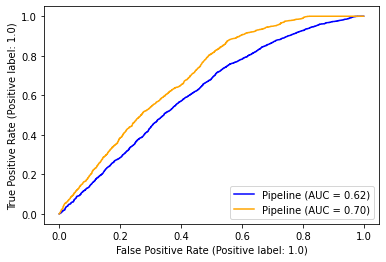

In [17]:
from sklearn.metrics import roc_curve, plot_roc_curve

# Logistic Regression ROC curve
logr = plot_roc_curve(model_logr, X_val, y_val, color='blue')

# Gradient Boosting ROC curve
gb = plot_roc_curve(model_gb, X_val, y_val, color='orange', ax = logr.ax_)


# Tune Model

#### RandomizedSearchCV - Iterate and find optimal hyperparameters

In [18]:
# Tune model and try out these hyperparameters for Gradient Boosting Classifier

param_grid = {
    'gradientboostingclassifier__loss': ['deviance', 'exponential'],
    'gradientboostingclassifier__n_estimators': range(100, 301, 50),
    'gradientboostingclassifier__criterion': ['friedman_mse', 'mse']
}

In [19]:
# Help me find which parameters to tune
model_gb.get_params();

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Create RandomizedSearchCV model
model_rs = RandomizedSearchCV(model_gb,
                              param_distributions=param_grid,
                              n_iter=10,
                              n_jobs=-1,
                              cv=5,
                              verbose=5,
                              random_state=42
                             )

model_rs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
# What were my optimal parameters?
model_rs.best_params_

In [ ]:
# Let's make our optimal parameters more readable
pd.DataFrame(data={'values': [100, 'exponential', 'mse'], 
                   'hyperparameter': ['n_estimators','loss','criterion']}).set_index('hyperparameter')
                    

In [ ]:
# What was the best model score with our optimal hyperparameters
model_rs.best_score_

In [ ]:
# Let's call our best model best_model
best_model = model_rs.best_estimator_
best_model

In [ ]:
# Let's find the best_model score on our Validation Data
best_model.score(X_val, y_val)

#### Permutation Importance - Use Permutation to find most influential features

In [ ]:
from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(best_model,
                                 X_val,
                                 y_val,
                                 n_repeats=5,
                                 n_jobs=-1,
                                 random_state=42)


In [ ]:
# Plot Permutation Importances in a DataFrame
data = {'imp_mean': perm_imp['importances_mean'].round(5),
       'imp_std': perm_imp['importances_std'].round(5)}

df_perm = pd.DataFrame(data, index=X_val.columns).sort_values('imp_mean')
df_perm

In [ ]:
# Plot Permutation Importances in a Horizontal Bar Chart
df_perm['imp_mean'].tail().plot(kind='barh')
plt.xlabel('% Increase to model')
plt.ylabel('Feature')
plt.title('Ranking Features by Permutation Importance');

# Communicate Results

In [ ]:
pdp_gb_ = model_rs.best_params_
pdp_gb_

In [ ]:
# Get to write this code below because Partial Dependence Plots (Classification) 
# & Shapley Plots can't handle pipelines.
# Encode manually. No other Transformers needed.

import category_encoders as ce
import shap

encoder = ce.OrdinalEncoder(handle_unknown='ignore')
XT_train = encoder.fit_transform(X_train)
XT_val = encoder.fit_transform(X_val)
XT_test = encoder.fit_transform(X_test)

# This model is the same as best_model
pdp_gb = GradientBoostingClassifier(random_state=42, loss='exponential', criterion='mse')

pdp_gb.fit(XT_train, y_train)

#### Partial Dependence Plot - One variable

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature='source'

isolate = pdp_isolate(model=pdp_gb,
                     dataset=XT_val,
                     model_features=X_val.columns,
                     feature=feature)

In [ ]:
# Automate x-axis labeling
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping']
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

In [ ]:
pdp_plot(isolate, feature)

# Automatically change the xticks labels
plt.ylabel('Predicted Demand Surge Probability')
plt.xticks(category_codes, category_names, rotation=45, size=12);

In [ ]:
feature2='name'

isolate2 = pdp_isolate(model=pdp_gb,
                     dataset=XT_val,
                     model_features=X_val.columns,
                     feature=feature2)

# Automate x-axis labeling
for item in encoder.mapping:
    if item['col'] == feature2:
        feature_mapping2 = item['mapping']
        
feature_mapping2 = feature_mapping2[feature_mapping2.index.dropna()]
category_names2 = feature_mapping2.index.tolist()
category_codes2 = feature_mapping2.values.tolist()

pdp_plot(isolate2, feature2)

# Automatically change the xticks labels
plt.ylabel('Predicted Demand Surge Probability')
plt.xticks(category_codes2, category_names2, rotation=45, size=12);

In [ ]:
# Used for reference to find what our encoder values mean
encoder.mapping;

In [ ]:
# Let's make this mapping easier to visualize

pd.DataFrame({'name': [1,2,3,4,5,6], 'mapping': ['Lyft','Lux Black XL','Lyft XL','Lux','Lux Black','Shared']}).set_index('name')

In [ ]:
# Let's make this mapping easier to visualize

pd.DataFrame({'source': [1,2,3,4,5,6,7,8,9,10,11,12], 
              'mapping': ['North End','Theatre District','Northeastern University','Fenway','Back Bay',
                          'Boston University','Haymarket Square','Financial District','West End',
                          'North Station','South Station','Beacon Hill']}).set_index('source')
             

#### Partial Dependence Plot (PDP) - Two Variables

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

features = ['source', 'name']

interaction = pdp_interact(model=pdp_gb,
                     dataset=XT_val,
                     model_features=X_val.columns,
                     features=features)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

#### Shapley Plot

In [ ]:
# Let's grab one observation from dataset
# XT_val[5:6] for prediction 0
# XT_val.head(1) for prediction 1

row = XT_val[5:6]
row

In [ ]:
# What is our model prediction for this observation?
pdp_gb.predict(row)

In [ ]:
pdp_gb.predict_proba(row)

In [ ]:
explainer = shap.TreeExplainer(pdp_gb) # No pipelines
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(explainer.expected_value,
               shap_values,
               features=row,
               link='logit' # For classification, this shows predicted probabilities
               )

# There is a 0.30 probability that the prediction will be 1, therefore predict 0
# This visualization doesn't map properly to prediction probability, something to look into...

### What day of the week is most popular?

In [ ]:
# Monday == 0, Sunday == 6

weekday = df[df['demand_surge'] == 1]['weekday'].value_counts(normalize=True)
weekday

### What hour of the day is most popular?

In [ ]:
hour = df[df['demand_surge'] == 1]['hour'].value_counts(normalize=True)
hour

### What day of the week and hour of the day is most popular?

In [ ]:
# Monday == 0, Sunday == 6

surge_df = df[df['demand_surge'] == 1]
group = (surge_df[['weekday', 'hour']]
                    .groupby(['weekday', 'hour'])
                    .size()
                    .reset_index(name='count'))
group

In [ ]:
import seaborn as sns

surges = group.pivot('weekday', 'hour', 'count')

f, ax = plt.subplots(figsize=(20,10))
sns.heatmap(surges)

# Adjust x and y axes
plt.xticks(rotation=0, size=15)
plt.yticks([0,1,2,3,4,5,6], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
           rotation=0, size=15)
plt.xlabel('Hour', fontsize=20)
plt.ylabel('Weekday', fontsize=20);

# Test Data

In [ ]:
best_model.score(X_test, y_test)